In [4]:
%load_ext autoreload
%autoreload 2

import sys
import os

# Dynamically add project root to sys.path
PROJECT_ROOT = os.path.abspath("..")  # Adjust if necessary
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

# Verify sys.path
print("Project root added to sys.path:", PROJECT_ROOT)

from utils.config import *

from src.adjustcls import *
from src.adjustl1 import *
from src.decomposer import *
from utils.loadsimulation import *

plt.rcParams.update({
    'axes.titlesize': 22,            # Font size for the plot titles
    'axes.labelsize': 20,            # Font size for the x and y labels
    'legend.fontsize': 16,           # Font size for the legend
    'xtick.labelsize': 20,           # Font size for the x-tick labels
    'ytick.labelsize': 20,           # Font size for the y-tick labels
    'axes.linewidth': 3.5,           # Width of the axes' lines
    'xtick.major.width': 3.25,       # Width of the major x-tick lines
    'ytick.major.width': 3.25,       # Width of the major y-tick lines
    'xtick.minor.width': 4.0,        # Width of the minor x-tick lines
    'ytick.minor.width': 4.0,        # Width of the minor y-tick lines
    'figure.titlesize': 20,          # Font size for figure titles
    'legend.handlelength': 2,        # Length of the legend lines
    'legend.handleheight': 0.7,      # Height of the legend markers
    'legend.labelspacing': 0.5,      # Vertical spacing between legend entries
    'lines.linewidth': 3.0,          # Line width for plot lines
    'lines.markersize': 3,           # Size of markers in plot lines
    'axes.grid': False,               # Enable grid on all plots
    'grid.alpha': 0.75,              # Set gridline transparency
    'grid.linestyle': '--',          # Set gridline style
    'grid.linewidth': 0.7,           # Set gridline width
    'grid.color': 'gray',            # Set gridline color
})

Project root added to sys.path: /feynman/work/dap/lcs/vt272285/Generative modelling of convergence map


### Testing the powerspectrum adjuster using a target and a gaussian map

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


the target pixelsize is:  0.5859375
the target size is:  (1024, 1024)


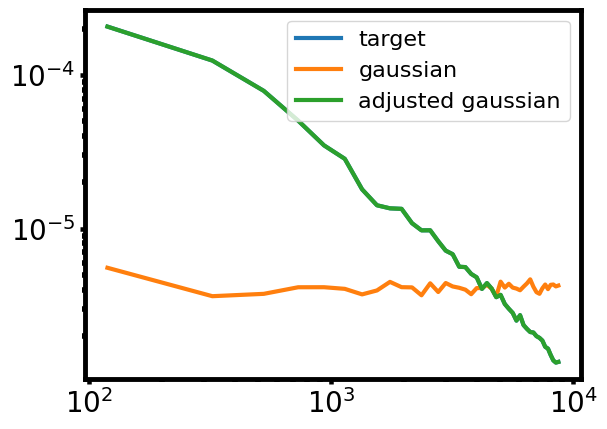

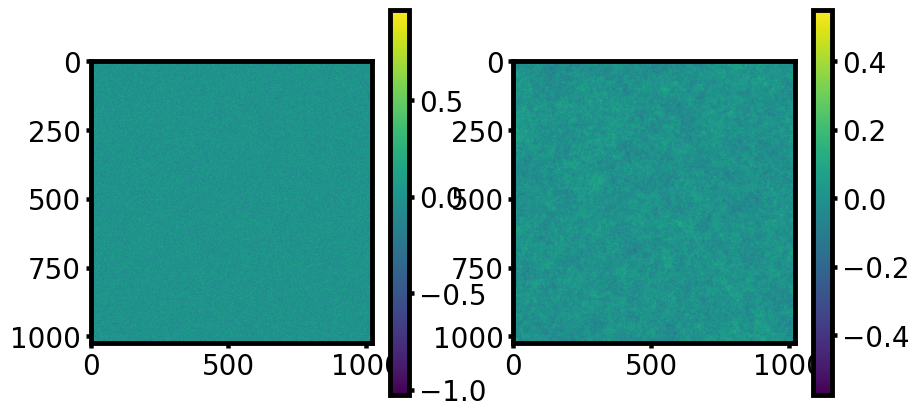

In [5]:
path = '/feynman/work/dap/lcs/vt272285/data/SLICS/2.007kappa_weight.dat_LOS400'
angle = 10
loader = SimulationDataLoader(user_defined_angle=angle) 

loaded_data, loaded_angle = loader.load_data(path)
data_downscaled = downscale_local_mean(loaded_data-np.mean(loaded_data), (4, 4))


N = 256*4
target = data_downscaled[:N,:N]
pixelsize = loaded_angle.value * 60 / target.shape[0]  # arcmin
print("the target pixelsize is: ", pixelsize)
print("the target size is: ", target.shape)

pkadjuster = PowerSpectrum(target, pixelsize)
_, target_ells, target_cls = pkadjuster.calculate_Cls(target)

new_shape = 256*4
gaussian = np.random.normal(0,0.2, (new_shape,new_shape))
pkadjuster = PowerSpectrum(gaussian, pixelsize)

adjusted_gaussian = pkadjuster.generate_field_with_target_cls(gaussian, target_cls, target_ells)
for i in range(5):  
    adjusted_gaussian = pkadjuster.generate_field_with_target_cls(adjusted_gaussian, target_cls, target_ells)

_, gaussian_ells, gaussian_cls = pkadjuster.calculate_Cls(gaussian)
_, adjusted_gaussian_ells, adjusted_gaussian_cls = pkadjuster.calculate_Cls(adjusted_gaussian)

plt.loglog(target_ells, target_cls, label='target')
plt.loglog(gaussian_ells, gaussian_cls, label='gaussian')
plt.loglog(adjusted_gaussian_ells, adjusted_gaussian_cls, label='adjusted gaussian')
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(gaussian)
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(adjusted_gaussian)
plt.colorbar()
plt.show()


### Testing l1-norm adjustment using a target and a gaussian map

the target pixelsize is:  0.5859375
the target size is:  (1024, 1024)


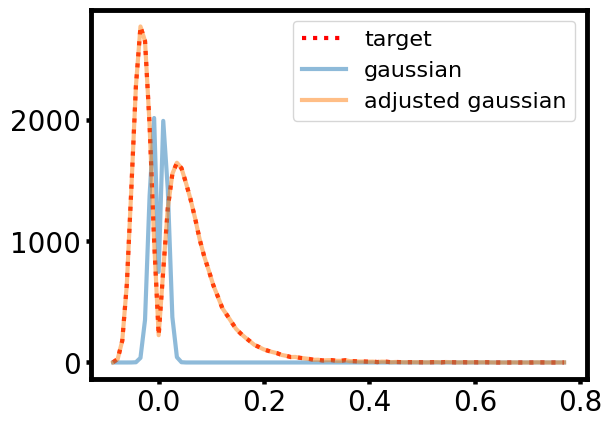

In [6]:
path = '/feynman/work/dap/lcs/vt272285/data/SLICS/2.007kappa_weight.dat_LOS400'
angle = 10
loader = SimulationDataLoader(user_defined_angle=angle) 

loaded_data, loaded_angle = loader.load_data(path)
data_downscaled = downscale_local_mean(loaded_data-np.mean(loaded_data), (4, 4))

N = 1024
target = data_downscaled[:N,:N]
pixelsize = loaded_angle.value * 60 / target.shape[0]  # arcmin
print("the target pixelsize is: ", pixelsize)
print("the target size is: ", target.shape)

gaussian = np.random.normal(0,0.01, (N,N))

target_edges, target_centers, target_hist, target_l1norm = calculate_histogram_l1norm(target, mask=None, nbins=100, density=False)
target_values = {'binedges': target_edges, 'bincenters': target_centers, 'histogram': target_hist, 'l1_norm': target_l1norm}
gaussian_edges, gaussian_centers, gaussian_hist, gaussian_l1norm = calculate_histogram_l1norm(gaussian, mask=None, nbins=target_edges, density=False)

adjusted_gaussian, _ = adjust_map_l1(gaussian, mask=None, targetvalues=target_values)

adjusted_edges, adjusted_centers, adjusted_hist, adjusted_l1norm = calculate_histogram_l1norm(adjusted_gaussian, mask=None, nbins=target_edges)

plt.plot(target_centers, target_l1norm, label='target', ls=":",c='r' )
plt.plot(gaussian_centers, gaussian_l1norm, label='gaussian', alpha=0.5)
plt.plot(adjusted_centers, adjusted_l1norm, label='adjusted gaussian', alpha=0.5)
plt.legend()
plt.show()

### Testing the reconstruction

In [ ]:
path = '/feynman/work/dap/lcs/vt272285/data/SLICS/2.007kappa_weight.dat_LOS400'
angle = 10
loader = SimulationDataLoader(user_defined_angle=angle) 

loaded_data, loaded_angle = loader.load_data(path)
data_downscaled = downscale_local_mean(loaded_data-np.mean(loaded_data), (4, 4))

N = 1024
filter_type = 'tophat'
nscales = 5
nbins = [200,200, 150, 200,100, 51, 100]
target = data_downscaled[:N,:N]
pixelsize = loaded_angle.value * 60 / target.shape[0]  # arcmin
print("the target pixelsize is: ", pixelsize)
print("the target size is: ", target.shape)

adjuster = PowerSpectrumAdjuster(map_shape=target.shape, pixel_size=pixelsize)
target_ells, target_cls = adjuster.compute_power_spectrum(target)

decomposer = WaveletDecomposer()

target_values = process_image(target, filter_type, nscales, nbins, adjuster, decomposer, density=False)

gaussian = np.random.normal(0,0.1, target.shape)
adjuster = PowerSpectrumAdjuster(map_shape=gaussian.shape, pixel_size=pixelsize)

solution = gaussian
total_error = []

plt.figure()
plt.imshow(target - np.sum(target_values['coefs'], axis=0))
plt.colorbar()
plt.show()